In [1]:
#%matplotlib inline
%matplotlib agg
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pdb
from IPython import display
import math
from functools import reduce
import operator

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features.cuda()
# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
def matrix_diff(m, m_tar):
    md = m_tar.mean()
    std = m_tar.std()
    m_tar = (m_tar-md) / std
    m = (m-md) / std
    diff = (m - m_tar) ** 2
    return torch.mean(diff) * 100

In [4]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, -1).clone()
    gram = torch.mm(tensor, tensor.t())
    return gram / (h*w)

In [5]:
def content_loss(img, tar):
    return matrix_diff(img, tar)

In [6]:
def style_loss(img, gram_tar):
    gram_img = gram_matrix(img)
    return matrix_diff(gram_img, gram_tar)

In [7]:
def extract_layers(input, layer_desc):
    layer_desc = {layer_id2idx[key]:val for key,val in layer_desc.items()}
    x = input
    res = {}
    for idx, layer in enumerate(vgg.children()):
        x = layer(x)
        if idx in layer_desc:
            res[idx]= x.clone(), layer_desc[idx]
    return res

In [8]:
class StyleTrainer():
    def __init__(self, img_size, content_layers = {}, style_layers = {}, content_path=None, style_path=None,lr=0.1):
        self.img_size, self.content_layers, self.style_layers, self.lr = img_size, content_layers, style_layers, lr
        self.content_path, self.style_path = content_path, style_path
        self.img = get_random_img(img_size)   
        self.init_learning()
        last_layer = max(set(self.content_target.keys()).union(set(self.style_target.keys())))
        self.model_layers = list(vgg.children())[:last_layer+1]
        
    def init_learning(self):
        self.img.requires_grad = True
        self.optim = optim.Adam([self.img], lr=self.lr)
        if len(self.content_layers) > 0:
            content = load_image(self.content_path, size=self.img_size)
            self.content_target = extract_layers(content, self.content_layers)
        else: 
            self.content_target = {}
        if len(self.style_layers) > 0:
            style = load_image(self.style_path, size=self.img_size)
            targets = extract_layers(style, self.style_layers)
            self.style_target = {idx: (gram_matrix(x), m) for idx, (x,m) in targets.items()}
        else:
            self.style_target = {}
    
    def upscale(self):    
        self.img = F.interpolate(self.img,scale_factor=2).detach_()
        self.img_size *= 2
        self.init_learning()
        
        
    def set_learning_rate(self,lr):
        self.lr = lr
        self.optim = optim.Adam([self.img], lr=self.lr)
    
    def __str__(self):
        return "content: {" + ",".join(self.content_layers.keys()) + "} style: {" + ",".join(self.style_layers.keys()) +"}"
    
    def train(self, steps):
        for st in range(steps):
            style_lss = torch.tensor(0.0).cuda()
            content_lss = torch.tensor(0.0).cuda()
            x = self.img
            for idx, layer in enumerate(self.model_layers):
                x = layer(x)
                if idx in self.content_target:
                    target, mul = self.content_target[idx]
                    content_lss +=  content_loss(x, target) * mul
                if idx in self.style_target:
                    target, mul = self.style_target[idx]
                    style_lss += style_loss(x, target) * mul
            lss = style_lss + content_lss
            self.optim.zero_grad()
            lss.backward()
            self.optim.step()
            #TODO clip
        return content_lss.item(), style_lss.item()

In [9]:
#Helper functions for loading images, converting them to tensors and back
normalize_params = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
def img2tensor(image, size = None):
    tfms = [
            transforms.ToTensor(),
            transforms.Normalize(*normalize_params)]
    if size is not None:
        tfms.insert(0, transforms.Resize((size,size)))
    image = transforms.Compose(tfms)(image)  
    return image[None].cuda()

def tensor2img(tensor):
    image = tensor.data.cpu().squeeze().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array(normalize_params[1]) + np.array(normalize_params[0])
    image = image.clip(0, 1)

    return image

def load_image(img_path, size=512):
    image = Image.open(img_path).convert('RGB')
    image = img2tensor(image, size)
    # discard the transparent, alpha channel 
    image = image[:,:3,:,:]
    return image

In [10]:
def show_all(images, captions=[], title=None):
    img_n = len(images)
    cols = min(4,int(math.ceil(np.sqrt(img_n))))
    rows = (img_n+cols-1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(8*cols,8*rows))
    fig.suptitle(title)
    if len(images) > 1: axs = axs.flatten()
    else: axs = [axs]
    for idx, img in enumerate(images):
        ax = axs[idx]
        ax.imshow(tensor2img(img))
        ax.axis('off')
        if idx < len(captions):
            ax.set_title(captions[idx])

    plt.close()
    
    return fig

In [11]:
def show_training(trainers, losses, title):
    imgs = [trn.img for trn in trainers]
    captions = [f'{str(tr)} lss: {ls[0] :.2f}, {ls[1] :.2f}' for tr, ls in zip(trainers, losses)]
    return show_all(imgs, captions, title)

In [12]:
#generates random noise image
def get_random_img(size):
    img = np.random.uniform(0, 1, size=(size,size,3))
    img_pil = Image.fromarray(np.uint8(img * 255))
    return img2tensor(img_pil)

In [13]:
l_idx =1 
l_d = 1
layer_id2idx ={}
for idx, layer in enumerate(vgg.children()):
    layer_id = f'{l_d}_{l_idx}'
    layer_id2idx[layer_id] = idx
    print(layer_id + ':', layer)
    if isinstance(layer, nn.MaxPool2d):
        l_d +=1
        l_idx = 1
    else:
        l_idx +=1

1_1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_2: ReLU(inplace)
1_3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_4: ReLU(inplace)
1_5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2_1: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_2: ReLU(inplace)
2_3: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_4: ReLU(inplace)
2_5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3_1: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_2: ReLU(inplace)
3_3: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_4: ReLU(inplace)
3_5: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_6: ReLU(inplace)
3_7: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_8: ReLU(inplace)
3_9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
4_1: Conv2d(256, 512, kernel_s

# Content Extraction

In [14]:
short_net = nn.Sequential(*list(vgg.children())[:layer_id2idx['2_4']+1])
short_net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
)

In [ ]:
content_x = load_image('images/grumpy.jpg', 128)
img_x = get_random_img(128)
show_all([content_x, img_x])

In [ ]:
content_y = short_net(content_x)
img_y = short_net(img_x)
print('activation shape', content_y.shape)
print('loss ', content_loss(content_y, img_y))

### Let's use backpropagation to get content_y and img_y closer together

In [17]:
img_x.requires_grad = True
opt = optim.Adam([img_x],lr = 0.1)
for epoch in range(500):
    img_y = short_net(img_x)
    loss = torch.mean((img_y-content_y)**2)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward1>)


In [ ]:
show_all([img_x])

What do we really do when we say we are extracting content?
Not this:

In [ ]:
show_all([content_y[0,:3,:,:]])

What we are actually doing is trying to solve the equation

 **short_net(img_x) = content_y**
 
 where **short_net** is a function that combines +,* and max() operations


In [20]:
#The number of variables in our equation
input_variables = reduce(operator.mul, img_x.shape)
output_variables = reduce(operator.mul, content_y.shape)
input_variables, output_variables

(49152, 524288)

relu and maxpool operations are making it hard to recreate the original image since they are discarding information. We get better accuracy in areas where activations are strong, that is near features the network was trained to detect. 

That's why using output of a convent works better for a style transfer than for example taking direct distance from the original image.

In [ ]:
#How is our loss spatially distributed on the layer 2_4

diff = (img_y-content_y)**2
diff.squeeze_()
spatial_loss = diff.mean(dim=0)
fig, axs = plt.subplots(1,1)
axs.imshow(spatial_loss.data.cpu().numpy(), cmap='hot')
display.display(fig)



## Extracting content for some other layers

In [ ]:
%%time
content_layers = [{'1_1':1}, {'1_4':1}, {'2_1':1},{'2_4':1}, {'3_1':1},{'3_8':1}, {'4_1':1},{'4_8':1}]

size = 32
content_path = 'images/grumpy.jpg'

trainers = [StyleTrainer(size, content_layers = cl,content_path = content_path) for cl in content_layers]

display.display(show_all([trn.img for trn in trainers], title = f'size: {size} epoch: 0'))
step_epochs = 20
while size < 128:
    for i in range(5):
        losses = []
        for trainer in trainers:
            losses.append(trainer.train(step_epochs))
        display.clear_output(wait=True)
        display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+1)*step_epochs}'))
    for trn in trainers:
        trn.upscale()
    size *=2
for i in range(10):
    losses = []
    for trainer in trainers:
        losses.append(trainer.train(step_epochs))
    display.clear_output(wait=True)
    display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+11)*step_epochs}'))

# Style Loss

In [ ]:
%%time
style_layers = [{'1_1':1}, {'1_4':1}, {'2_1':1},{'2_4':1}, {'3_1':1},{'3_8':1}]

size = 32
style_path = 'images/painting.jpg'

trainers = [StyleTrainer(size, style_layers = sl ,style_path=style_path) for sl in style_layers]

display.display(show_all([trn.img for trn in trainers], title = f'size: {size} epoch: 0'))
step_epochs = 20
while size < 256:
    for i in range(10):
        losses = []
        for trainer in trainers:
            losses.append(trainer.train(step_epochs))
        display.clear_output(wait=True)
        display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+1)*step_epochs}'))
    for trn in trainers:
        trn.upscale()
    size *=2
for i in range(10):
    losses = []
    for trainer in trainers:
        losses.append(trainer.train(step_epochs))
    display.clear_output(wait=True)
    display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+21)*step_epochs}'))


## Putting it together

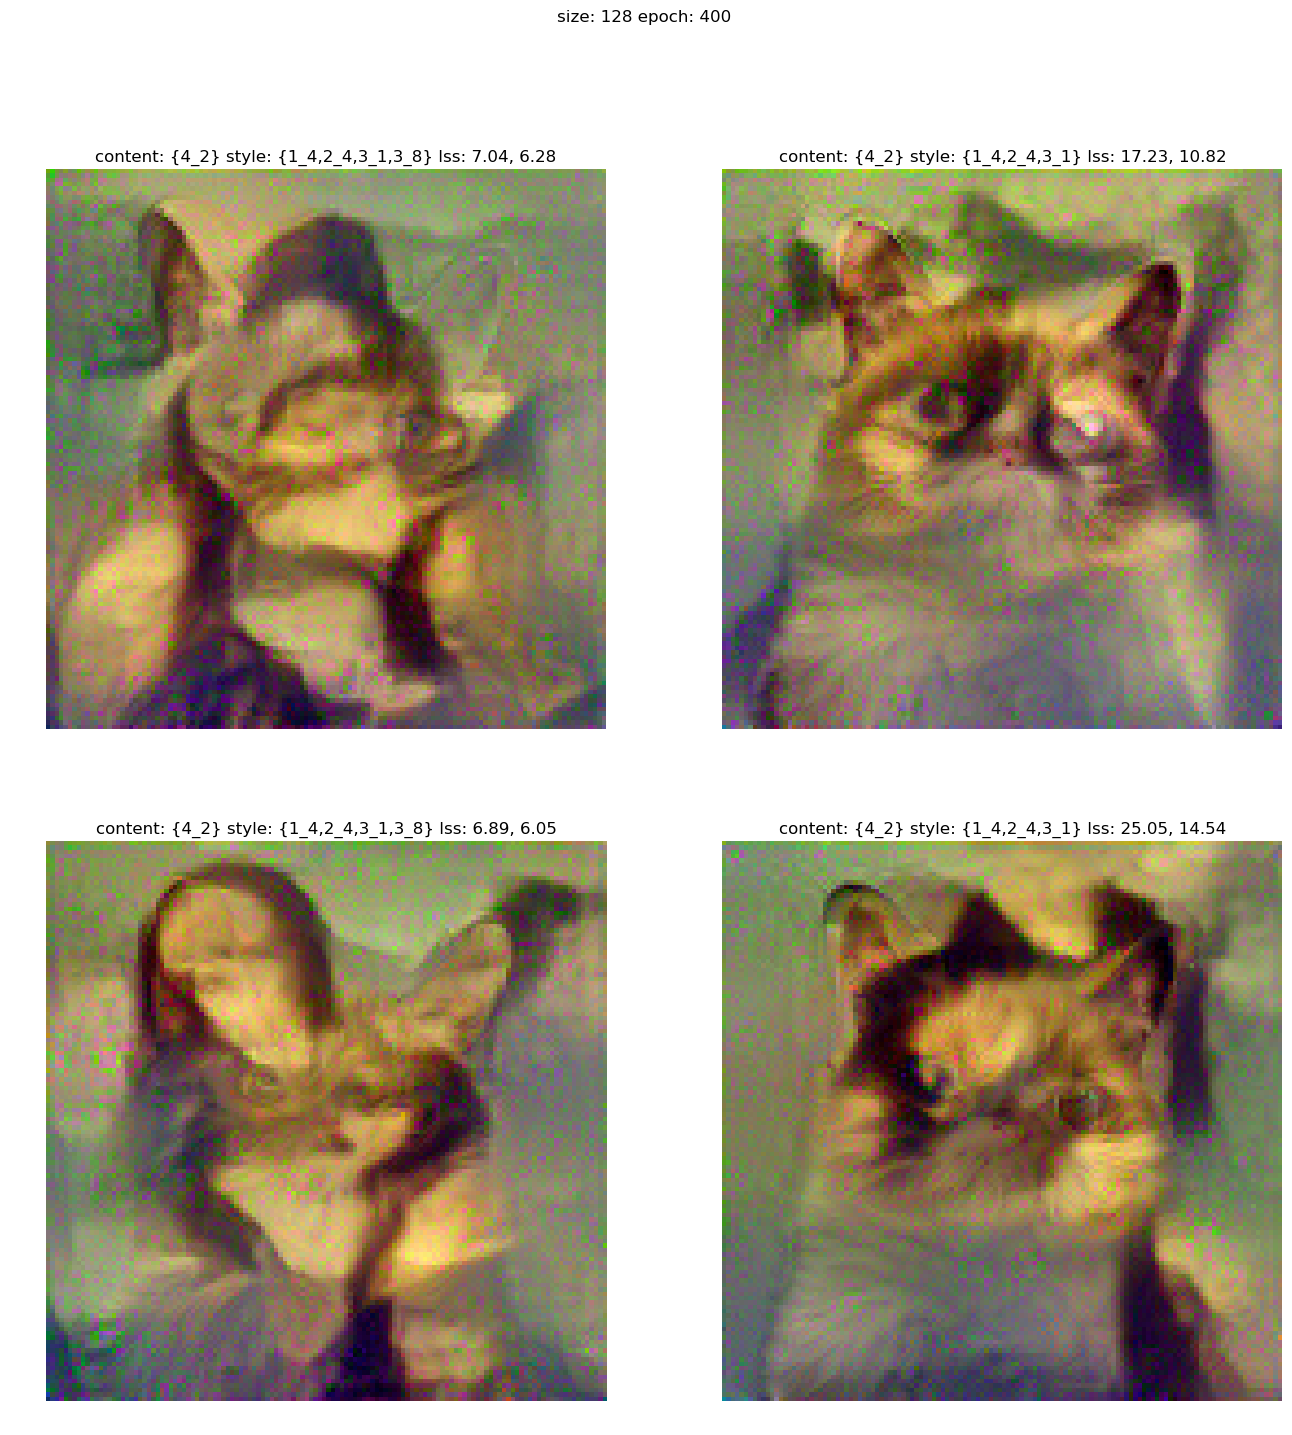

In [104]:
style_layers = [
    {'1_4':1, '2_4':1,'3_1':.1, '3_8':.1},
    {'1_4':1, '2_4':1, '3_1':.1},
    {'1_4':1, '2_4':1, '3_1':.1, '3_8':.1},
    {'1_4':10, '2_4':1, '3_1':.1},
]
content_layers = [{'4_2':.1}, {'4_2':1},{'4_2':.1}, {'4_2':1}]

size = 32
content_path = 'images/grumpy.jpg'
style_path = 'images/mona.jpg'

trainers = []
for cl,sl in zip(content_layers,style_layers):
    trainer = StyleTrainer(size, content_layers = cl,style_layers = sl ,content_path = content_path, style_path=style_path)
    trainers.append(trainer)


display.display(show_all([trn.img for trn in trainers], title = f'size: {size} epoch: 0'))
step_epochs = 20
while size < 128:
    for i in range(10):
        losses = []
        for trainer in trainers:
            losses.append(trainer.train(step_epochs))
        display.clear_output(wait=True)
        display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+1)*step_epochs}'))
    for trn in trainers:
        trn.upscale()
    size *=2
for i in range(10):
    losses = []
    for trainer in trainers:
        losses.append(trainer.train(step_epochs))
    display.clear_output(wait=True)
    display.display(show_training( trainers, losses, f'size: {size} epoch: {(i+11)*step_epochs}'))


In [119]:
trainer = trainers[2]
trainer.upscale()

(13.000284194946289, 42.12196731567383)
(10.22275447845459, 10.282087326049805)
(8.073408126831055, 6.73176383972168)
(6.915914058685303, 5.629931449890137)
(6.2516584396362305, 5.043641090393066)
(5.835238456726074, 4.646081447601318)
(5.539346218109131, 4.348458290100098)
(5.314296245574951, 4.110558032989502)
(5.1249308586120605, 3.923473358154297)
(4.979036331176758, 3.753952980041504)
(4.84977388381958, 3.6119701862335205)
(4.741779804229736, 3.4809906482696533)
(4.639277935028076, 3.3681867122650146)
(4.549330711364746, 3.2640910148620605)
(4.469722270965576, 3.1690902709960938)
(4.396705150604248, 3.0830066204071045)
(4.331849575042725, 3.0009853839874268)
(4.273489952087402, 2.923762798309326)
(4.2213335037231445, 2.8506577014923096)
(4.171913146972656, 2.7833080291748047)


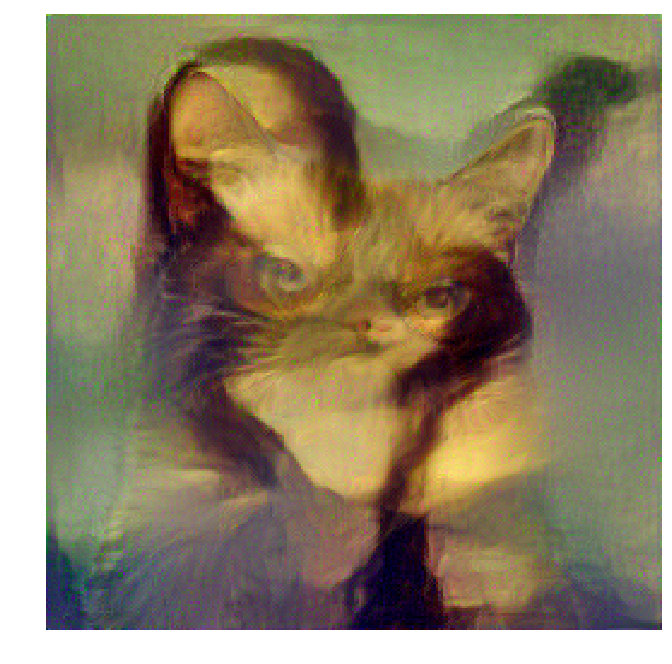

In [120]:
for i in range(20):
    print(trainer.train(20))
show_all([trainer.img])

In [121]:
trainer.upscale()

(9.448817253112793, 7.68760871887207)
(6.209980487823486, 3.358628749847412)
(4.923602104187012, 2.589069366455078)
(4.330663681030273, 2.2814197540283203)
(3.9921536445617676, 2.09544038772583)
(3.76335072517395, 1.9602597951889038)
(3.6066811084747314, 1.845458984375)
(3.4835243225097656, 1.7540018558502197)
(3.391467332839966, 1.6866021156311035)
(3.3219761848449707, 1.6209094524383545)
(3.1587648391723633, 1.5992677211761475)
(3.2219090461730957, 1.5668624639511108)
(3.0891361236572266, 1.594541311264038)
(3.025432825088501, 1.4861717224121094)
(2.9150094985961914, 1.6402844190597534)
(2.9093551635742188, 1.3562309741973877)
(2.834273099899292, 1.3047831058502197)
(2.7895896434783936, 1.2621088027954102)
(2.7877118587493896, 1.5174750089645386)
(2.855839252471924, 1.4704039096832275)


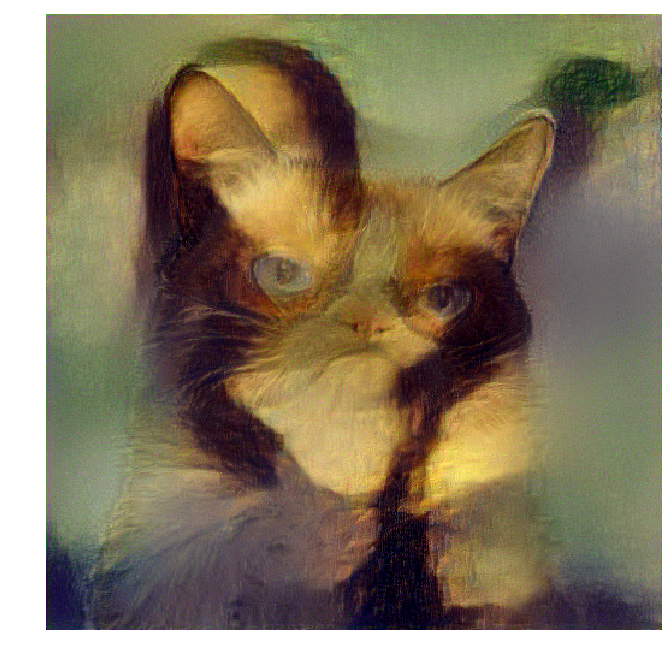

In [122]:
for i in range(20):
    print(trainer.train(20))
show_all([trainer.img])

In [123]:
trainer.set_learning_rate(.01)

(2.750138759613037, 1.2213187217712402)
(2.6202054023742676, 1.1649396419525146)
(2.5736968517303467, 1.1354420185089111)
(2.550079107284546, 1.1140165328979492)
(2.5340123176574707, 1.0956335067749023)
(2.520247220993042, 1.0791149139404297)
(2.5077569484710693, 1.0631355047225952)
(2.4951212406158447, 1.048534631729126)
(2.4835855960845947, 1.0338528156280518)
(2.4732015132904053, 1.0191152095794678)


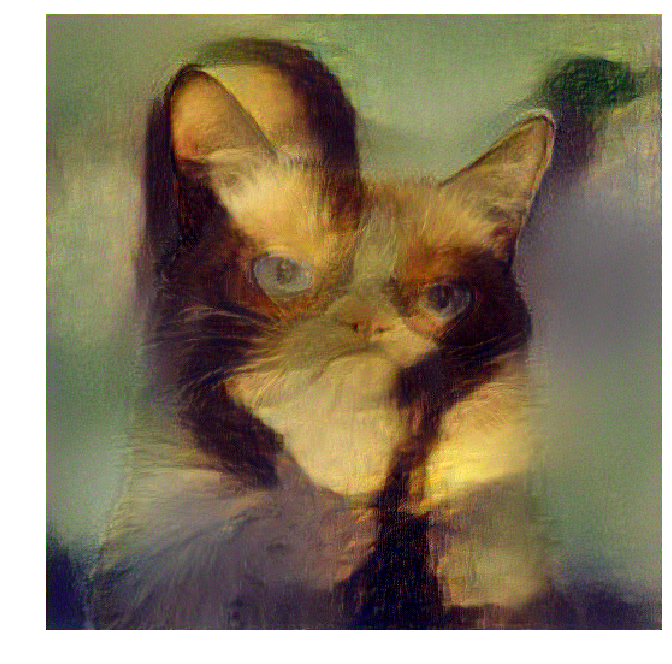

In [124]:
for i in range(10):
    print(trainer.train(20))
show_all([trainer.img])

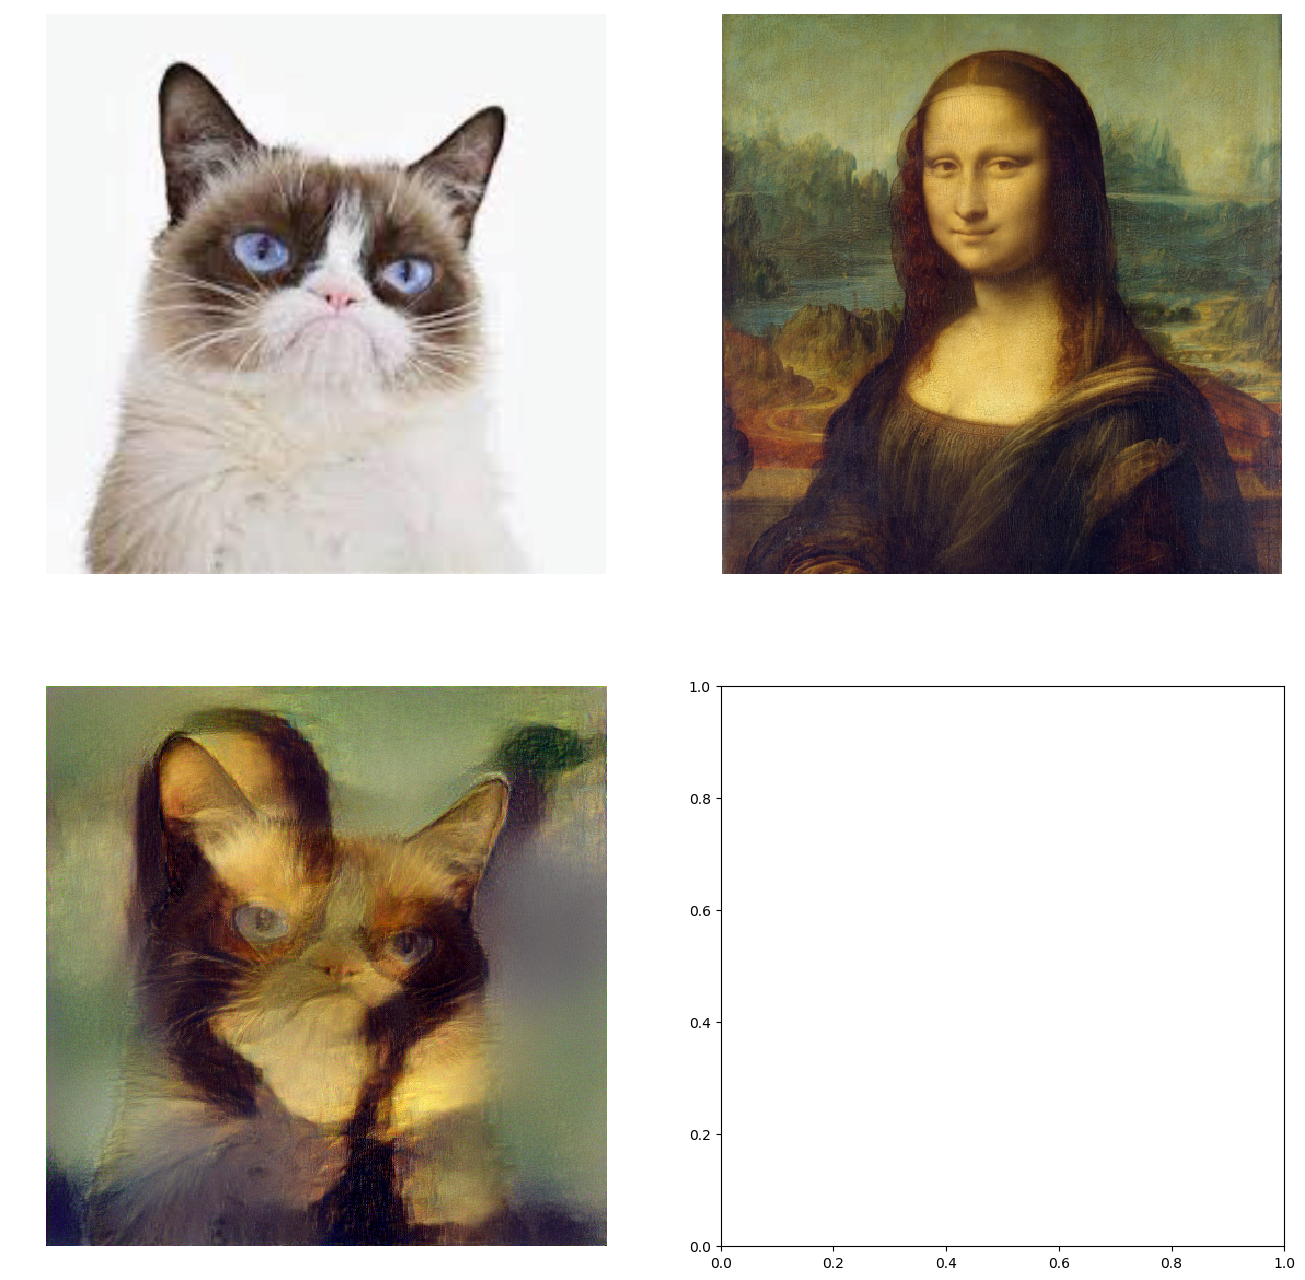

In [125]:
show_all([load_image(content_path), load_image(style_path), trainer.img])

In [126]:
plt.imsave('mycat.jpg',tensor2img(trainer.img))